In [1]:
import pandas as pd
import numpy as np
import json
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from tqdm import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Hyperparameters
MAX_VOCAB_SIZE = 10000
MAX_SEQ_LENGTH = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 64
BATCH_SIZE = 32
LEARNING_RATE = 0.0008
NUM_EPOCHS = 15
DROPOUT_RATE = 0.6
FOCAL_LOSS_GAMMA = 2.0  # Parameter for focal loss

## Load Data

In [3]:
# File paths (Kaggle)
TRAIN_PATH = '/kaggle/input/deception/train (1).jsonl'
VALIDATION_PATH = '/kaggle/input/deception/validation.jsonl'
TEST_PATH = '/kaggle/input/deception/test.jsonl'

# File paths (local)
#TRAIN_PATH = 'data/train.jsonl'
#VALIDATION_PATH = 'data/validation.jsonl'
#TEST_PATH = 'data/test.jsonl'

In [4]:
# Load and preprocess data
def load_data(file_path):
    data = []
    with open(file_path, 'r') as f:
        for line in f:
            game_data = json.loads(line.strip())

            for i in range(len(game_data['messages'])):
                if game_data['sender_labels'][i] == "NOANNOTATION":
                    continue

                entry = {
                    'message': game_data['messages'][i],
                    'speaker': game_data['speakers'][i],
                    'receiver': game_data['receivers'][i],
                    'score_delta': float(game_data['game_score_delta'][i]) if 'game_score_delta' in game_data else 0,
                    'abs_msg_idx': game_data['absolute_message_index'][i],
                    'rel_msg_idx': game_data['relative_message_index'][i],
                    'year': int(game_data['years'][i]) if 'years' in game_data else 1900,
                    'season': game_data['seasons'][i] if 'seasons' in game_data else "Unknown",
                    'message_length': len(game_data['messages'][i]),
                    'is_deceptive': 1 if game_data['sender_labels'][i] == False else 0  # deceptive=1, truthful=0
                }
                data.append(entry)

    return pd.DataFrame(data)

In [5]:
# Load datasets
print("Loading datasets...")
train_df = load_data(TRAIN_PATH)
val_df = load_data(VALIDATION_PATH)
test_df = load_data(TEST_PATH)

Loading datasets...


In [6]:
print(f"Train size: {len(train_df)}, Validation size: {len(val_df)}, Test size: {len(test_df)}")

Train size: 13132, Validation size: 1416, Test size: 2741


In [7]:
# Show class distribution
print("Class distribution in training data:")
class_dist = train_df['is_deceptive'].value_counts(normalize=True)
print(class_dist)

Class distribution in training data:
is_deceptive
0    0.954995
1    0.045005
Name: proportion, dtype: float64


## Preprocess Data

In [8]:
# Text preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [9]:
# Apply preprocessing
train_df['processed_message'] = train_df['message'].apply(preprocess_text)
val_df['processed_message'] = val_df['message'].apply(preprocess_text)
test_df['processed_message'] = test_df['message'].apply(preprocess_text)

In [10]:
# Extract season as one-hot encoded feature
def encode_season(season):
    seasons = ['Spring', 'Summer', 'Fall', 'Winter']
    encoding = [0] * len(seasons)
    try:
        idx = seasons.index(season)
        encoding[idx] = 1
    except ValueError:
        pass
    return encoding

In [11]:
# Apply season encoding
train_df['season_encoded'] = train_df['season'].apply(encode_season)
val_df['season_encoded'] = val_df['season'].apply(encode_season)
test_df['season_encoded'] = test_df['season'].apply(encode_season)

In [12]:
# Normalize year
def normalize_year(year):
    return (year - 1900) / 10

In [13]:
# Normalize year
train_df['year_normalized'] = train_df['year'].apply(normalize_year)
val_df['year_normalized'] = val_df['year'].apply(normalize_year)
test_df['year_normalized'] = test_df['year'].apply(normalize_year)

In [14]:
# Normalize message length
def normalize_length(length):
    return min(length / 100, 5)

In [15]:
# Normalize message length
train_df['length_normalized'] = train_df['message_length'].apply(normalize_length)
val_df['length_normalized'] = val_df['message_length'].apply(normalize_length)
test_df['length_normalized'] = test_df['message_length'].apply(normalize_length)

In [16]:
# Save processed data
train_df.to_csv('train_processed.csv', index=False)
val_df.to_csv('val_processed.csv', index=False)
test_df.to_csv('test_processed.csv', index=False)

## Dataset

In [17]:
# Build vocabulary
def build_vocab(texts, max_size):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    for word, _ in word_counts.most_common(max_size - len(vocab)):
        if word not in vocab:
            vocab[word] = len(vocab)

    return vocab

In [18]:
print("Building vocabulary...")
vocab = build_vocab(train_df['processed_message'], MAX_VOCAB_SIZE)
print(f"Vocabulary size: {len(vocab)}")

Building vocabulary...
Vocabulary size: 8633


In [19]:
def tokenize(text, vocab, max_length):
    words = text.split()
    tokens = [vocab.get(word, vocab['<UNK>']) for word in words[:max_length]]

    if len(tokens) < max_length:
        tokens = tokens + [vocab['<PAD>']] * (max_length - len(tokens))

    return tokens

In [20]:
# Dataset class
class DiplomacyDataset(Dataset):
    def __init__(self, dataframe, vocab, max_length):
        self.messages = [tokenize(text, vocab, max_length) for text in dataframe['processed_message']]
        self.score_deltas = dataframe['score_delta'].values
        self.rel_msg_indices = dataframe['rel_msg_idx'].values / 10.0  # Normalize
        self.abs_msg_indices = dataframe['abs_msg_idx'].values / 1000.0  # Normalize
        self.years = dataframe['year_normalized'].values
        self.seasons = np.stack(dataframe['season_encoded'].values)
        self.message_lengths = dataframe['length_normalized'].values
        self.labels = dataframe['is_deceptive'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'message': torch.tensor(self.messages[idx], dtype=torch.long),
            'score_delta': torch.tensor(self.score_deltas[idx], dtype=torch.float),
            'rel_msg_idx': torch.tensor(self.rel_msg_indices[idx], dtype=torch.float),
            'abs_msg_idx': torch.tensor(self.abs_msg_indices[idx], dtype=torch.float),
            'year': torch.tensor(self.years[idx], dtype=torch.float),
            'season': torch.tensor(self.seasons[idx], dtype=torch.float),
            'msg_length': torch.tensor(self.message_lengths[idx], dtype=torch.float),
            'label': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [21]:
# Create datasets
print("Creating datasets...")
train_dataset = DiplomacyDataset(train_df, vocab, MAX_SEQ_LENGTH)
val_dataset = DiplomacyDataset(val_df, vocab, MAX_SEQ_LENGTH)
test_dataset = DiplomacyDataset(test_df, vocab, MAX_SEQ_LENGTH)

Creating datasets...


In [22]:
# Calculate class weights for weighted sampling
class_counts = np.bincount(train_df['is_deceptive'])
class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df['is_deceptive']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_df), replacement=True)

In [23]:
# Create data loaders with weighted sampler for training
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## Model

In [24]:
# Focal Loss implementation
class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha 
        self.size_average = size_average
        if alpha is not None:
            self.criterion = nn.CrossEntropyLoss(weight=alpha, reduction='none')
        else:
            self.criterion = nn.CrossEntropyLoss(reduction='none')

    def forward(self, inputs, targets):
        ce_loss = self.criterion(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.size_average:
            return focal_loss.mean()
        else:
            return focal_loss.sum()

In [25]:
# LSTM Model with attention
class DeceptionLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout_rate, num_layers=2):
        super(DeceptionLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                           batch_first=True, bidirectional=True, dropout=dropout_rate if num_layers > 1 else 0)

        # Attention mechanism
        self.attention = nn.Linear(hidden_dim * 2, 1)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)
        self.feature_layer = nn.Linear(9, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim * 2 + hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)

    def attention_net(self, lstm_output):
        attn_weights = torch.tanh(self.attention(lstm_output))
        soft_attn_weights = torch.softmax(attn_weights, dim=1)
        context = torch.bmm(lstm_output.transpose(1, 2), soft_attn_weights)
        return context.squeeze(2)

    def forward(self, message, score_delta, rel_msg_idx, abs_msg_idx, year, season, msg_length):
        embedded = self.embedding(message)
        lstm_out, _ = self.lstm(embedded)
        attn_out = self.attention_net(lstm_out)
        attn_out = self.dropout(attn_out)

        features = torch.cat([
            score_delta.unsqueeze(1),
            rel_msg_idx.unsqueeze(1),
            abs_msg_idx.unsqueeze(1),
            year.unsqueeze(1),
            season,  
            msg_length.unsqueeze(1)
        ], dim=1)

        feature_out = torch.relu(self.feature_layer(features))
        combined = torch.cat([attn_out, feature_out], dim=1)
        hidden = torch.relu(self.fc1(combined))
        hidden = self.dropout(hidden)
        output = self.fc2(hidden)

        return output

In [26]:
# Initialize model
model = DeceptionLSTM(
    vocab_size=len(vocab),
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    dropout_rate=DROPOUT_RATE,
    num_layers=2
)

In [27]:
# Calculate class weights for loss function
class_counts = np.bincount(train_df['is_deceptive'])
class_weights = torch.FloatTensor([1.0 / class_counts[0], 1.0 / class_counts[1]])
class_weights = class_weights / class_weights.sum()  
class_weights = class_weights * 2  

In [28]:
# Define loss function
criterion = FocalLoss(gamma=FOCAL_LOSS_GAMMA, alpha=class_weights)

In [29]:
# Added L2 regularization
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)

In [30]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Train and Evaluate

In [31]:
# Training function
def train_epoch(model, data_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []

    for batch in tqdm(data_loader, desc="Training"):
        messages = batch['message'].to(device)
        score_deltas = batch['score_delta'].to(device)
        rel_msg_indices = batch['rel_msg_idx'].to(device)
        abs_msg_indices = batch['abs_msg_idx'].to(device)
        years = batch['year'].to(device)
        seasons = batch['season'].to(device)
        msg_lengths = batch['msg_length'].to(device)
        labels = batch['label'].to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(messages, score_deltas, rel_msg_indices, abs_msg_indices, years, seasons, msg_lengths)
        loss = criterion(outputs, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1

In [32]:
# Evaluation function
def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []  

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            # Get data
            messages = batch['message'].to(device)
            score_deltas = batch['score_delta'].to(device)
            rel_msg_indices = batch['rel_msg_idx'].to(device)
            abs_msg_indices = batch['abs_msg_idx'].to(device)
            years = batch['year'].to(device)
            seasons = batch['season'].to(device)
            msg_lengths = batch['msg_length'].to(device)
            labels = batch['label'].to(device)

            # Forward pass
            outputs = model(messages, score_deltas, rel_msg_indices, abs_msg_indices, years, seasons, msg_lengths)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            probs = torch.softmax(outputs, dim=1)
            all_probs.extend(probs[:, 1].cpu().numpy())  

            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)


    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    print(cm)

    f1 = f1_score(all_labels, all_preds, average='macro')

    return total_loss / len(data_loader), accuracy, f1, all_preds, all_probs, all_labels

In [33]:
# Find optimal threshold
def find_optimal_threshold(y_true, y_probs):
    best_f1 = 0
    best_threshold = 0.5

    for threshold in np.arange(0.1, 0.9, 0.05):
        y_pred = (np.array(y_probs) >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred, average='macro')

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

In [34]:
# Plot confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')

In [35]:
# Training loop
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs, device):
    best_val_f1 = 0.0
    history = {'train_loss': [], 'train_acc': [], 'train_f1': [],
               'val_loss': [], 'val_acc': [], 'val_f1': []}

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")

        # Train
        train_loss, train_acc, train_f1 = train_epoch(model, train_loader, optimizer, criterion, device)

        # Validate
        val_loss, val_acc, val_f1, _, val_probs, val_labels = evaluate(model, val_loader, criterion, device)
        scheduler.step(val_f1)
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        #Finding optimal threshold
        threshold, _ = find_optimal_threshold(val_labels, val_probs)
        print(f"Optimal threshold: {threshold:.2f}")

        #best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'threshold': threshold,
                'epoch': epoch
            }, '/kaggle/working//best_model.pt')
            print("Saved best model!")

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_f1'], label='Train F1')
    plt.plot(history['val_f1'], label='Val F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

    return model, threshold

## Execution

In [36]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [37]:
# Move model and criterion to device
model = model.to(device)
criterion = criterion.to(device)

Starting training...
Epoch 1/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 316.18it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0162, Train Acc: 0.5049, Train F1: 0.3361
Val Loss: 0.0092, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.10
Saved best model!
Epoch 2/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 316.15it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0086, Train Acc: 0.4953, Train F1: 0.3312
Val Loss: 0.0074, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 3/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 319.09it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0080, Train Acc: 0.5008, Train F1: 0.3337
Val Loss: 0.0091, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 4/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 314.34it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1360
           1       0.04      1.00      0.08        56

    accuracy                           0.04      1416
   macro avg       0.02      0.50      0.04      1416
weighted avg       0.00      0.04      0.00      1416


Confusion Matrix:
[[   0 1360]
 [   0   56]]
Train Loss: 0.0072, Train Acc: 0.5028, Train F1: 0.3346
Val Loss: 0.0064, Val Acc: 0.0395, Val F1: 0.0380
Optimal threshold: 0.85
Epoch 5/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 317.21it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.13      0.22      1360
           1       0.04      0.91      0.08        56

    accuracy                           0.16      1416
   macro avg       0.51      0.52      0.15      1416
weighted avg       0.94      0.16      0.22      1416


Confusion Matrix:
[[ 173 1187]
 [   5   51]]
Train Loss: 0.0059, Train Acc: 0.5033, Train F1: 0.3399
Val Loss: 0.0121, Val Acc: 0.1582, Val F1: 0.1519
Optimal threshold: 0.85
Saved best model!
Epoch 6/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 315.88it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.14      0.24      1360
           1       0.04      0.91      0.08        56

    accuracy                           0.17      1416
   macro avg       0.51      0.52      0.16      1416
weighted avg       0.94      0.17      0.24      1416


Confusion Matrix:
[[ 188 1172]
 [   5   51]]
Train Loss: 0.0054, Train Acc: 0.5237, Train F1: 0.3890
Val Loss: 0.0104, Val Acc: 0.1688, Val F1: 0.1609
Optimal threshold: 0.85
Saved best model!
Epoch 7/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 311.74it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.41      0.58      1360
           1       0.05      0.77      0.10        56

    accuracy                           0.43      1416
   macro avg       0.51      0.59      0.34      1416
weighted avg       0.94      0.43      0.56      1416


Confusion Matrix:
[[561 799]
 [ 13  43]]
Train Loss: 0.0045, Train Acc: 0.6446, Train F1: 0.5905
Val Loss: 0.0264, Val Acc: 0.4266, Val F1: 0.3380
Optimal threshold: 0.85
Saved best model!
Epoch 8/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 297.33it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.50      0.66      1360
           1       0.05      0.68      0.10        56

    accuracy                           0.51      1416
   macro avg       0.51      0.59      0.38      1416
weighted avg       0.94      0.51      0.64      1416


Confusion Matrix:
[[680 680]
 [ 18  38]]
Train Loss: 0.0041, Train Acc: 0.6952, Train F1: 0.6620
Val Loss: 0.0399, Val Acc: 0.5071, Val F1: 0.3795
Optimal threshold: 0.85
Saved best model!
Epoch 9/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 318.57it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.48      0.64      1360
           1       0.05      0.71      0.10        56

    accuracy                           0.49      1416
   macro avg       0.51      0.60      0.37      1416
weighted avg       0.94      0.49      0.62      1416


Confusion Matrix:
[[651 709]
 [ 16  40]]
Train Loss: 0.0043, Train Acc: 0.6634, Train F1: 0.6205
Val Loss: 0.0324, Val Acc: 0.4880, Val F1: 0.3709
Optimal threshold: 0.85
Epoch 10/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 296.32it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.42      0.58      1360
           1       0.05      0.77      0.10        56

    accuracy                           0.43      1416
   macro avg       0.51      0.59      0.34      1416
weighted avg       0.94      0.43      0.56      1416


Confusion Matrix:
[[566 794]
 [ 13  43]]
Train Loss: 0.0038, Train Acc: 0.7138, Train F1: 0.6878
Val Loss: 0.0283, Val Acc: 0.4301, Val F1: 0.3401
Optimal threshold: 0.85
Epoch 11/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 318.12it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.49      0.65      1360
           1       0.05      0.68      0.10        56

    accuracy                           0.49      1416
   macro avg       0.51      0.58      0.37      1416
weighted avg       0.94      0.49      0.63      1416


Confusion Matrix:
[[661 699]
 [ 18  38]]
Train Loss: 0.0041, Train Acc: 0.7388, Train F1: 0.7190
Val Loss: 0.0369, Val Acc: 0.4936, Val F1: 0.3721
Optimal threshold: 0.85
Epoch 12/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 304.74it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.54      0.69      1360
           1       0.04      0.52      0.08        56

    accuracy                           0.54      1416
   macro avg       0.50      0.53      0.39      1416
weighted avg       0.93      0.54      0.67      1416


Confusion Matrix:
[[733 627]
 [ 27  29]]
Train Loss: 0.0032, Train Acc: 0.7621, Train F1: 0.7469
Val Loss: 0.0593, Val Acc: 0.5381, Val F1: 0.3865
Optimal threshold: 0.85
Saved best model!
Epoch 13/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 313.32it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.53      0.69      1360
           1       0.05      0.66      0.10        56

    accuracy                           0.54      1416
   macro avg       0.51      0.60      0.39      1416
weighted avg       0.94      0.54      0.66      1416


Confusion Matrix:
[[721 639]
 [ 19  37]]
Train Loss: 0.0029, Train Acc: 0.7808, Train F1: 0.7694
Val Loss: 0.0498, Val Acc: 0.5353, Val F1: 0.3939
Optimal threshold: 0.85
Saved best model!
Epoch 14/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 312.72it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.51      0.67      1360
           1       0.05      0.66      0.10        56

    accuracy                           0.52      1416
   macro avg       0.51      0.59      0.38      1416
weighted avg       0.94      0.52      0.65      1416


Confusion Matrix:
[[694 666]
 [ 19  37]]
Train Loss: 0.0028, Train Acc: 0.8028, Train F1: 0.7957
Val Loss: 0.0540, Val Acc: 0.5162, Val F1: 0.3835
Optimal threshold: 0.85
Epoch 15/15


Evaluating: 100%|██████████| 45/45 [00:00<00:00, 304.29it/s]



Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76      1360
           1       0.06      0.54      0.10        56

    accuracy                           0.62      1416
   macro avg       0.51      0.58      0.43      1416
weighted avg       0.93      0.62      0.74      1416


Confusion Matrix:
[[854 506]
 [ 26  30]]
Train Loss: 0.0028, Train Acc: 0.7885, Train F1: 0.7796
Val Loss: 0.0799, Val Acc: 0.6243, Val F1: 0.4319
Optimal threshold: 0.85
Saved best model!


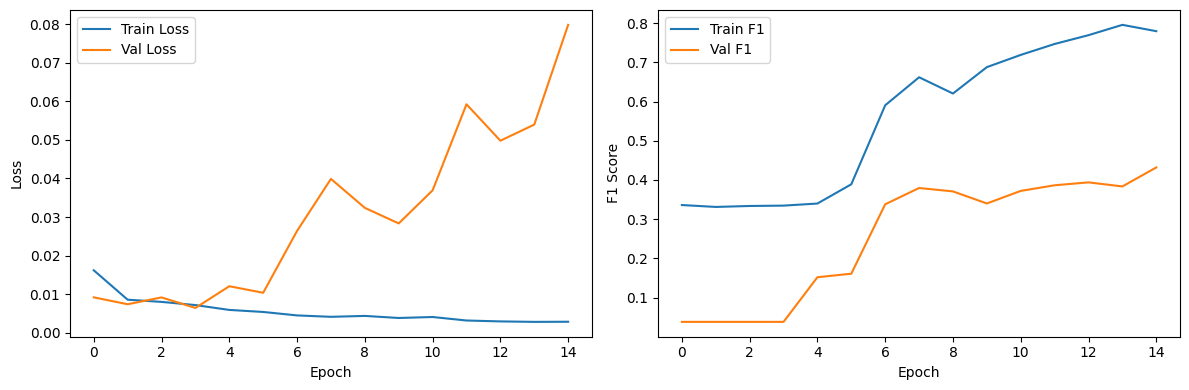

In [38]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Train model
print("Starting training...")
model, threshold = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    num_epochs=NUM_EPOCHS,
    device=device
)

## Load and evaluate model

In [39]:
# Load best model
checkpoint = torch.load('/kaggle/working//best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
threshold = checkpoint['threshold']
print(f"Loaded best model from epoch {checkpoint['epoch']+1} with threshold {threshold:.2f}")

Loaded best model from epoch 15 with threshold 0.85


<ipython-input-39-2b0d69fc4bcf>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working//best_model.pt')


In [40]:
# Evaluate on test set
print("Evaluating on test set...")
test_loss, test_acc, test_f1, test_preds, test_probs, test_labels = evaluate(model, test_loader, criterion, device)

Evaluating on test set...


Evaluating: 100%|██████████| 86/86 [00:00<00:00, 315.84it/s]


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73      2501
           1       0.10      0.45      0.16       240

    accuracy                           0.60      2741
   macro avg       0.51      0.53      0.45      2741
weighted avg       0.85      0.60      0.68      2741


Confusion Matrix:
[[1522  979]
 [ 131  109]]


In [41]:
# Apply optimal threshold
test_preds_threshold = (np.array(test_probs) >= threshold).astype(int)
threshold_acc = accuracy_score(test_labels, test_preds_threshold)
threshold_f1 = f1_score(test_labels, test_preds_threshold, average='macro')

In [42]:
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Test F1: {test_f1:.4f}")
print(f"With optimal threshold: Test Acc: {threshold_acc:.4f}, Test F1: {threshold_f1:.4f}")

Test Loss: 0.1963, Test Acc: 0.5950, Test F1: 0.4485
With optimal threshold: Test Acc: 0.6680, Test F1: 0.4746


In [43]:
# Print classification report with optimal threshold
print("\nClassification Report (with optimal threshold):")
print(classification_report(test_labels, test_preds_threshold))


Classification Report (with optimal threshold):
              precision    recall  f1-score   support

           0       0.92      0.70      0.79      2501
           1       0.10      0.35      0.16       240

    accuracy                           0.67      2741
   macro avg       0.51      0.52      0.47      2741
weighted avg       0.85      0.67      0.74      2741



In [44]:
# Print confusion matrix with optimal threshold
print("\nConfusion Matrix (with optimal threshold):")
cm = confusion_matrix(test_labels, test_preds_threshold)
print(cm)


Confusion Matrix (with optimal threshold):
[[1747  754]
 [ 156   84]]


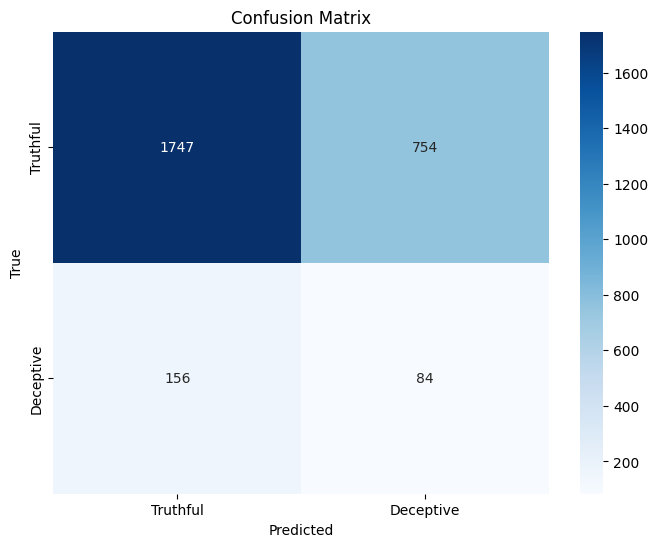

In [45]:
# Plot confusion matrix
plot_confusion_matrix(cm, ['Truthful', 'Deceptive'])

In [46]:
# Save predictions
test_predictions = pd.DataFrame({
    'predicted_prob': test_probs,
    'predicted_label': test_preds_threshold,
    'true_label': test_labels
})
test_predictions.to_csv('test_predictions.csv', index=False)

print("Test predictions saved.")


Test predictions saved.
